In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.5 MB/s eta 0:00:00


#LOAD DATASET

In [5]:
import skfuzzy as fuzz
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#Use only Glucose, BMI, and Age features for fuzzy logic

In [7]:
data = df[['Glucose', 'BMI', 'Age']]

In [8]:
data.describe()

,Glucose,BMI,Age
count,768.000000,768.000000,768.000000
mean,120.894531,31.992578,33.240885
std,31.972618,7.884160,11.760232
min,0.000000,0.000000,21.000000
25%,99.000000,27.300000,24.000000
50%,117.000000,32.000000,29.000000
75%,140.250000,36.600000,41.000000
max,199.000000,67.100000,81.000000


# Define fuzzy membership functions

In [9]:
x_glucose = np.arange(0, 201, 1)
x_bmi = np.arange(0, 51, 1)
x_age = np.arange(20, 81, 1)
x_risk = np.arange(0, 101, 1)

In [10]:
glucose_low = fuzz.trimf(x_glucose, [0, 0, 120])
glucose_med = fuzz.trimf(x_glucose, [90, 130, 170])
glucose_high = fuzz.trimf(x_glucose, [140, 200, 200])

In [11]:
bmi_low = fuzz.trimf(x_bmi, [0, 0, 18])
bmi_med = fuzz.trimf(x_bmi, [15, 25, 35])
bmi_high = fuzz.trimf(x_bmi, [30, 50, 50])

In [12]:
age_young = fuzz.trimf(x_age, [20, 20, 35])
age_middle = fuzz.trimf(x_age, [30, 45, 60])
age_old = fuzz.trimf(x_age, [55, 80, 80])

In [13]:
risk_low = fuzz.trimf(x_risk, [0, 0, 40])
risk_med = fuzz.trimf(x_risk, [30, 50, 70])
risk_high = fuzz.trimf(x_risk, [60, 100, 100])

#Define fuzzy inference rules

In [14]:
glucose_val = data.iloc[0]['Glucose']
bmi_val = data.iloc[0]['BMI']
age_val = data.iloc[0]['Age']

In [15]:
g_low = fuzz.interp_membership(x_glucose, glucose_low, glucose_val)
g_med = fuzz.interp_membership(x_glucose, glucose_med, glucose_val)
g_high = fuzz.interp_membership(x_glucose, glucose_high, glucose_val)

In [16]:
b_low = fuzz.interp_membership(x_bmi, bmi_low, bmi_val)
b_med = fuzz.interp_membership(x_bmi, bmi_med, bmi_val)
b_high = fuzz.interp_membership(x_bmi, bmi_high, bmi_val)

a_young = fuzz.interp_membership(x_age, age_young, age_val)
a_middle = fuzz.interp_membership(x_age, age_middle, age_val)
a_old = fuzz.interp_membership(x_age, age_old, age_val)

#Apply fuzzy rules and aggregate

In [17]:
rule1 = np.fmax(np.fmin(g_high, b_high), a_old)

rule2 = np.fmin(g_med, b_med)

rule3 = np.fmin(np.fmin(g_low, b_low), a_young)

In [18]:
risk_activation_high = np.fmin(rule1, risk_high)
risk_activation_med = np.fmin(rule2, risk_med)
risk_activation_low = np.fmin(rule3, risk_low)

In [19]:
aggregated = np.fmax(risk_activation_low, np.fmax(risk_activation_med, risk_activation_high))

In [20]:
risk_score = fuzz.defuzz(x_risk, aggregated, 'centroid')

In [21]:
if risk_score < 40:
    risk_label = "Low"
elif risk_score < 70:
    risk_label = "Medium"
else:
    risk_label = "High"

In [22]:
print("Input values:")
print(f"  Glucose: {glucose_val}")
print(f"  BMI: {bmi_val}")
print(f"  Age: {age_val}")
print("\nPredicted Risk Score:", round(risk_score, 2))
print("Diabetes Risk Level:", risk_label)

Input values:
  Glucose: 148.0
  BMI: 33.6
  Age: 50.0

Predicted Risk Score: 65.29
Diabetes Risk Level: Medium


#Combines Fuzzy + SVM

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [24]:
target = df['Outcome']

In [25]:
fuzzy_features = []

for i in range(len(data)):
    glucose_val = data.iloc[i]['Glucose']
    bmi_val = data.iloc[i]['BMI']
    age_val = data.iloc[i]['Age']

    g_low = fuzz.interp_membership(x_glucose, glucose_low, glucose_val)
    g_med = fuzz.interp_membership(x_glucose, glucose_med, glucose_val)
    g_high = fuzz.interp_membership(x_glucose, glucose_high, glucose_val)

    b_low = fuzz.interp_membership(x_bmi, bmi_low, bmi_val)
    b_med = fuzz.interp_membership(x_bmi, bmi_med, bmi_val)
    b_high = fuzz.interp_membership(x_bmi, bmi_high, bmi_val)

    a_young = fuzz.interp_membership(x_age, age_young, age_val)
    a_middle = fuzz.interp_membership(x_age, age_middle, age_val)
    a_old = fuzz.interp_membership(x_age, age_old, age_val)

    features = [
        max(g_low, 0.001), max(g_med, 0.001), max(g_high, 0.001),
        max(b_low, 0.001), max(b_med, 0.001), max(b_high, 0.001),
        max(a_young, 0.001), max(a_middle, 0.001), max(a_old, 0.001)
    ]

    fuzzy_features.append(features)

fuzzy_features = np.array(fuzzy_features)

In [26]:
fuzzy_risk_scores = []

for i in range(len(data)):
    glucose_val = data.iloc[i]['Glucose']
    bmi_val = data.iloc[i]['BMI']
    age_val = data.iloc[i]['Age']

    g_low = fuzz.interp_membership(x_glucose, glucose_low, glucose_val)
    g_med = fuzz.interp_membership(x_glucose, glucose_med, glucose_val)
    g_high = fuzz.interp_membership(x_glucose, glucose_high, glucose_val)

    b_low = fuzz.interp_membership(x_bmi, bmi_low, bmi_val)
    b_med = fuzz.interp_membership(x_bmi, bmi_med, bmi_val)
    b_high = fuzz.interp_membership(x_bmi, bmi_high, bmi_val)

    a_young = fuzz.interp_membership(x_age, age_young, age_val)
    a_middle = fuzz.interp_membership(x_age, age_middle, age_val)
    a_old = fuzz.interp_membership(x_age, age_old, age_val)

    # Aturan fuzzy
    rule1 = np.fmax(np.fmin(g_high, b_high), a_old)
    rule2 = np.fmin(g_med, b_med)
    rule3 = np.fmin(np.fmin(g_low, b_low), a_young)

    risk_activation_high = np.fmin(rule1, risk_high)
    risk_activation_med = np.fmin(rule2, risk_med)
    risk_activation_low = np.fmin(rule3, risk_low)

    aggregated = np.fmax(risk_activation_low,
                         np.fmax(risk_activation_med, risk_activation_high))

    try:
        risk_score = fuzz.defuzz(x_risk, aggregated, 'centroid')
    except:
        risk_score = 0  # atau np.nan jika ingin anggap invalid

    fuzzy_risk_scores.append(risk_score)

df['FuzzyRiskScore'] = fuzzy_risk_scores



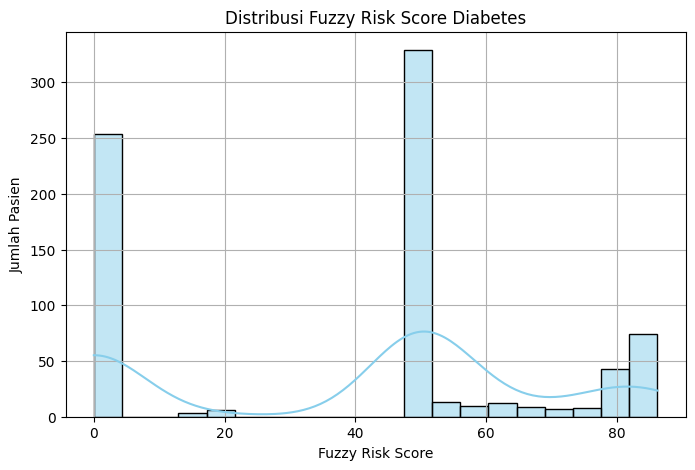

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df['FuzzyRiskScore'], kde=True, bins=20, color='skyblue')
plt.title("Distribusi Fuzzy Risk Score Diabetes")
plt.xlabel("Fuzzy Risk Score")
plt.ylabel("Jumlah Pasien")
plt.grid(True)
plt.show()


In [28]:
X_train, X_test, y_train, y_test = train_test_split(fuzzy_features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, probability=True)

#Predict on Random Input

In [30]:
def predict_diabetes_risk(glucose_input, bmi_input, age_input):

    g_low = fuzz.interp_membership(x_glucose, glucose_low, glucose_input)
    g_med = fuzz.interp_membership(x_glucose, glucose_med, glucose_input)
    g_high = fuzz.interp_membership(x_glucose, glucose_high, glucose_input)

    b_low = fuzz.interp_membership(x_bmi, bmi_low, bmi_input)
    b_med = fuzz.interp_membership(x_bmi, bmi_med, bmi_input)
    b_high = fuzz.interp_membership(x_bmi, bmi_high, bmi_input)

    a_young = fuzz.interp_membership(x_age, age_young, age_input)
    a_middle = fuzz.interp_membership(x_age, age_middle, age_input)
    a_old = fuzz.interp_membership(x_age, age_old, age_input)

    input_fuzzy = np.array([
        max(g_low, 0.001), max(g_med, 0.001), max(g_high, 0.001),
        max(b_low, 0.001), max(b_med, 0.001), max(b_high, 0.001),
        max(a_young, 0.001), max(a_middle, 0.001), max(a_old, 0.001)
    ])

    input_scaled = scaler.transform([input_fuzzy])

    prediction = svm_model.predict(input_scaled)[0]
    score = svm_model.predict_proba(input_scaled)[0][1]

    risk_level = "High" if prediction == 1 else "Low"

    print("\n Input Values")
    print(f" Glucose: {glucose_input}, BMI: {bmi_input}, Age: {age_input}")
    print("\n Predicted Diabetes Risk Level:", risk_level)
    print(" Risk Score:", round(score, 4))

In [31]:
predict_diabetes_risk(glucose_input=145, bmi_input=36.5, age_input=54)
predict_diabetes_risk(glucose_input=90, bmi_input=21.0, age_input=25)


 Input Values
 Glucose: 145, BMI: 36.5, Age: 54

 Predicted Diabetes Risk Level: High
 Risk Score: 0.6875

 Input Values
 Glucose: 90, BMI: 21.0, Age: 25

 Predicted Diabetes Risk Level: Low
 Risk Score: 0.1723
